In [14]:
!pip install langdetect

     |████████████████████████████████| 981 kB 6.1 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993191 sha256=e96607beb15bdd33259158c0fe232d4d94bd847ec9ee1d153794ba7da5318983
  Stored in directory: /root/.cache/pip/wheels/59/f6/9d/85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect


In [15]:
!pip install -q googletrans

In [16]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [17]:
#Set your project path 
#project_path =  "../"
#import os
#os.getcwd()

In [18]:
#Import libraries

import numpy as np
import pandas as pd
import re

# EDA


## Read Data

In [19]:
df = pd.read_excel('../input/ittickets/input_data.xlsx')
df.head()

Short description  \
0                    login issue   
1                        outlook   
2             cant log in to vpn   
3  unable to access hr_tool page   
4                   skype error    

                                         Description             Caller  \
0  -verified user details.(employee# & manager na...  spxjnwir pjlcoqds   
1  \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...  hmjdrvpb komuaywn   
2  \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...  eylqgodm ybqkwiam   
3                      unable to access hr_tool page  xbkucsvz gcpydteq   
4                                       skype error   owlgqjme qhcozdfx   

  Assignment group  
0            GRP_0  
1            GRP_0  
2            GRP_0  
3            GRP_0  
4            GRP_0

In [20]:
df.shape

(8500, 4)

Data has 4 columns: short description, description, caller and Assignment Groups.
From initial observations, there are lots of symbols and punctuations. The description fields also refer to the caller names. There are HTML tags, URL's, email addresses, references to image files etc which need to be cleaned. There are also some rows which are not in English (mostly German).

The target variable (Assignment group) will be studied in more detail further on. 

## Preprocessing

In [21]:
clean_df = df.copy()
clean_df = clean_df.astype(str)

In [22]:
# Fill NA values (2 rows only)
clean_df['Description'].fillna(value=' ', inplace=True)

### Language Detection

Language detection works best before the text is further processed.

In [23]:
from langdetect import detect
clean_df['Language'] = ""
for i, desc in enumerate(clean_df['Description']):
  try:
    clean_df['Language'][i] = detect(desc)
  except:
    clean_df['Language'][i] = 'unknown'
    

In [24]:
clean_df[clean_df['Language']!='en']

Short description  \
4                                          skype error    
14                             unable to open payslips    
19                              unable to sign into vpn   
22                             unable to connect to vpn   
25                           erp SID_37 password reset    
...                                                 ...   
8465                                   vpn è¿žæŽ¥ä¸ä¸Š   
8471                           ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥   
8475               etime- time card update information.   
8486                  ticket update on ticket_no0427635   
8499  an mehreren pc`s lassen sich verschiedene prgr...   

                                            Description             Caller  \
4                                          skype error   owlgqjme qhcozdfx   
14                             unable to open payslips   epwyvjsz najukwho   
19                              unable to sign into vpn  ftsqkvre bqzrupic   
22                             unable to connect to vpn  pfmcnahv ofzlusri   
25                           erp SID_37 password reset   jqhtkfsm xoehtbnl   
...                                                 ...                ...   
8465  vpnè¿žä¸ä¸Šï¼Œè¯·è½¬ç»™ è´ºæ­£å¹³ atcbvglq.bd...  fcvqezmn frzyjknu   
8471         to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥  xqyjztnm onfusvlz   
8475               etime- time card update information.  tmopbken ibzougsd   
8486                  ticket update on ticket_no0427635  fumkcsji sarmtlhy   
8499  an mehreren pc`s lassen sich verschiedene prgr...  kqvbrspl jyzoklfx   

     Assignment group Language  
4               GRP_0       no  
14              GRP_0       fr  
19              GRP_0       it  
22              GRP_0       es  
25              GRP_0       af  
...               ...      ...  
8465           GRP_30       ca  
8471           GRP_30       no  
8475            GRP_0       it  
8486            GRP_0       sv  
8499           GRP_49       de  

[1492 rows x 5 columns]

In [25]:
clean_df['Language'].value_counts()

en         7008
de          400
af          262
it          143
fr          124
sv           83
no           73
da           71
nl           62
ca           57
es           52
pl           33
pt           29
ro           19
tl           11
cy           11
et            9
sl            9
hr            7
sq            7
fi            6
tr            6
so            5
id            4
unknown       3
cs            2
sw            1
lv            1
sk            1
lt            1
Name: Language, dtype: int64

The language detection has not done a very good job of detecting languages. It has mostly correctly detected English and German and most other languages detected should have been marked as English. Therefore, we will only treat the German words (after cleaning the data).

### Clean


In [26]:
callers = clean_df['Caller'].tolist()

def clean_data(text):
    text = text.lower()
    #text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    # Remove email template
    text = re.sub(r"(received from:|from:|to:|sent:|ic:|cc:|bcc:).*\n",' ',text)
    text = re.sub(r"subject:",' ',text)

    #Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)

    # Remove numbers 
    text = re.sub(r'\s*\d+','' ,text)

    # Remove new line characters 
    text = re.sub(r'\n',' ',text)

    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)

    # Remove & 
    text = re.sub(r'&;?', 'and',text)

    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)

    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) 

    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 

    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    
    # Remove caller names
    for caller in callers:
      caller_names = [name for name in caller.split()]
      for name in caller_names: 
          text = text.replace(name,'')       
   
    text = text.strip()
    text = ' '.join(text.split())

    return text



In [27]:
# Merge short description and description fields
clean_df['Description'] = clean_df['Description'].apply(clean_data)
clean_df['Short description'] = clean_df['Short description'].apply(clean_data)
clean_df['Description'] = clean_df['Description'] +" "+ clean_df['Short description']

In [28]:
# Now drop short description
clean_df.drop('Short description', axis=1, inplace=True)
clean_df.head()

Description             Caller  \
0  verified user details employee and manager nam...  spxjnwir pjlcoqds   
1  hello team my meetings skype meetings etc are ...  hmjdrvpb komuaywn   
2  hi i cannot log on to vpn best cant log in to vpn  eylqgodm ybqkwiam   
3  unable to access hr tool page unable to access...  xbkucsvz gcpydteq   
4                            skype error skype error  owlgqjme qhcozdfx   

  Assignment group Language  
0            GRP_0       en  
1            GRP_0       en  
2            GRP_0       en  
3            GRP_0       en  
4            GRP_0       no

In [29]:
from googletrans import Translator

translator = Translator()

translations = clean_df[clean_df['Language']=='de']['Description'].apply(lambda x: translator.translate(x).text)

In [30]:
clean_df.loc[clean_df['Language']=='de','Description'] = translations
clean_df.loc[223]

Description         hello it happened again the pc hung up again a...
Caller                                              vrfpyjwi nzhvgqiw
Assignment group                                               GRP_24
Language                                                           de
Name: 223, dtype: object

In [31]:
clean_df[clean_df['Language']=='de'].head()


Description             Caller  \
133  install driver in printer hr in hostname insta...  bihypqsn kbaegpcd   
223  hello it happened again the pc hung up again a...  vrfpyjwi nzhvgqiw   
251  please reset password for e mail please new pa...  fygrwuna gomcekzi   
265  hello netweaver does not work anymore or I can...  fcyuqvoj ajqeidlm   
270  new password for account name tgryhu hgygrtui ...  nemzycxb xpsgkahw   

    Assignment group Language  
133            GRP_0       de  
223           GRP_24       de  
251            GRP_0       de  
265            GRP_0       de  
270            GRP_0       de

In [32]:
clean_df.to_excel('cleaned_data.xlsx')

### Stopword Removal & Lemmatization 

In [33]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

/opt/conda/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
# Remove stopwords
sw_en = stopwords.words('english')
#adding 'please' to stopwords as it appears frequently but does not add to context
sw_en.append('please')

for i, desc in enumerate(clean_df['Description']):
    clean_df['Description'][i]=' '.join(word for word in desc.split() if word not in sw_en)
    

In [35]:
clean_df['Description'].apply(lambda x: 'please' in x).any()

False

In [36]:
# Lemmatise

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wordnet_lemmatizer = WordNetLemmatizer()


text = clean_df['Description'][1000]
text_words = nltk.word_tokenize(text)

for word in text_words:
    print ("{0:20}{1:20}".format(word,wordnet_lemmatizer.lemmatize(word,pos=get_wordnet_pos(word))))


winwip              winwip              
working             work                
asking              ask                 
buy                 buy                 
trial               trial               
version             version             
validity            validity            
expired             expire              
winwip              winwip              
working             work                
asking              ask                 
buy                 buy                 
trial               trial               
version             version             
validity            validity            
expired             expire              


In [37]:
def lemmatize_text_en(text):
    words = text.split()
    return ' '.join([wordnet_lemmatizer.lemmatize(word,pos=get_wordnet_pos(word)) for word in words])

clean_df['Description'] = clean_df['Description'].apply(lemmatize_text_en)

clean_df['Description'][1000]

'winwip work ask buy trial version validity expire winwip work ask buy trial version validity expire'

In [38]:
clean_df['Description'][223]

'hello happen pc hung present blue screen white letter problem bluescreen'

In [39]:
clean_df.to_excel('cleaned_data_lem.xlsx')


In [40]:
#clean_df = pd.read_excel('../input/ittickets/cleaned_lem_data.xlsx')
#clean_df

### Topic Modelling

Use BOW and TFIDF for LDA modelling, then compare and visualise the results.

In [41]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

In [42]:
#Tokenisation
def desc_to_words(descs):
    for desc in descs:
        yield(gensim.utils.simple_preprocess(str(desc)))

data_words = list(desc_to_words(clean_df['Description']))

# check first description
print(data_words[0])

['verify', 'user', 'detail', 'employee', 'manager', 'name', 'checked', 'user', 'name', 'ad', 'reset', 'password', 'advise', 'user', 'login', 'check', 'caller', 'confirm', 'able', 'login', 'issue', 'resolve', 'login', 'issue']


In [43]:
# Create Dictinoary
id2word = corpora.Dictionary(data_words)
vocab_size = len(id2word)
print("Vocab size = ", vocab_size)

# Create Corpus
texts = data_words

# Term Document Frequency (Bag of Words)
bow_corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# View BOW and TFIDF for the first description
print(bow_corpus[0])
print(tfidf_corpus[0])


Vocab size =  10247
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 3), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1)]
[(0, 0.16040786768528723), (1, 0.22544856144122324), (2, 0.2124372101055551), (3, 0.24092420940091724), (4, 0.16586154193053965), (5, 0.2403066645699361), (6, 0.20963482244104237), (7, 0.1943678480397017), (8, 0.20413690747317925), (9, 0.22566719960849219), (10, 0.4607186690173273), (11, 0.17626745300879826), (12, 0.29361839762925357), (13, 0.10794751329235776), (14, 0.11858110424989528), (15, 0.1852799347703621), (16, 0.365133352482796), (17, 0.1943678480397017)]


In [44]:
# Readable format of BOW corpus (term-frequency) for first description
[[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus[:1]]

[[('able', 1),
  ('ad', 1),
  ('advise', 1),
  ('caller', 1),
  ('check', 1),
  ('checked', 1),
  ('confirm', 1),
  ('detail', 1),
  ('employee', 1),
  ('issue', 2),
  ('login', 3),
  ('manager', 1),
  ('name', 2),
  ('password', 1),
  ('reset', 1),
  ('resolve', 1),
  ('user', 3),
  ('verify', 1)]]

In [45]:
# Readable format of TFIDF corpus for first description
[[(id2word[id], tfi) for id, tfi in cp] for cp in tfidf_corpus[:1]]

[[('able', 0.16040786768528723),
  ('ad', 0.22544856144122324),
  ('advise', 0.2124372101055551),
  ('caller', 0.24092420940091724),
  ('check', 0.16586154193053965),
  ('checked', 0.2403066645699361),
  ('confirm', 0.20963482244104237),
  ('detail', 0.1943678480397017),
  ('employee', 0.20413690747317925),
  ('issue', 0.22566719960849219),
  ('login', 0.4607186690173273),
  ('manager', 0.17626745300879826),
  ('name', 0.29361839762925357),
  ('password', 0.10794751329235776),
  ('reset', 0.11858110424989528),
  ('resolve', 0.1852799347703621),
  ('user', 0.365133352482796),
  ('verify', 0.1943678480397017)]]

In [82]:
#Build an LDA model using BOW corpus
lda_model_bow = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=7,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [83]:
from pprint import pprint
pprint(lda_model_bow.print_topics())

[(0,
  '0.067*"tool" + 0.043*"connect" + 0.041*"microsoft" + 0.040*"screen" + '
  '0.039*"engineering" + 0.036*"unable" + 0.032*"internet" + 0.027*"language" '
  '+ 0.027*"summary" + 0.026*"name"'),
 (1,
  '0.141*"erp" + 0.103*"account" + 0.080*"sid" + 0.071*"ticket" + 0.055*"lock" '
  '+ 0.050*"update" + 0.032*"team" + 0.028*"create" + 0.020*"inc" + '
  '0.020*"computer"'),
 (2,
  '0.067*"outside" + 0.063*"software" + 0.042*"usa" + 0.038*"unlock" + '
  '0.033*"may" + 0.021*"germany" + 0.019*"day" + 0.017*"average" + '
  '0.016*"supply" + 0.016*"sample"'),
 (3,
  '0.092*"access" + 0.085*"yes" + 0.076*"na" + 0.038*"site" + 0.038*"deny" + '
  '0.029*"circuit" + 0.028*"power" + 0.028*"company" + 0.027*"vendor" + '
  '0.026*"network"'),
 (4,
  '0.102*"password" + 0.059*"reset" + 0.038*"id" + 0.033*"outlook" + '
  '0.031*"tool" + 0.026*"request" + 0.023*"change" + 0.022*"error" + '
  '0.021*"file" + 0.020*"service"'),
 (5,
  '0.366*"job" + 0.138*"scheduler" + 0.105*"abended" + 0.047*"fail" 

In [84]:
# Compute Perplexity
print('Perplexity: ', lda_model_bow.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_bow = CoherenceModel(model=lda_model_bow, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_bow = coherence_model_lda_bow.get_coherence()
print('\nCoherence Score: ', coherence_lda_bow)

Perplexity:  -7.340171430092546

Coherence Score:  0.41372052925918795


In [85]:
#Build an LDA model using BOW corpus
lda_model_tfi = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=7,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [87]:
pprint(lda_model_tfi.print_topics())

[(0,
  '0.053*"request" + 0.047*"skype" + 0.045*"log" + 0.029*"screen" + '
  '0.027*"time" + 0.017*"bex" + 0.017*"report" + 0.014*"set" + 0.013*"let" + '
  '0.012*"meeting"'),
 (1,
  '0.067*"update" + 0.042*"software" + 0.028*"client" + 0.027*"team" + '
  '0.024*"inc" + 0.024*"computer" + 0.023*"create" + 0.022*"inplant" + '
  '0.020*"supply" + 0.020*"chain"'),
 (2,
  '0.063*"access" + 0.055*"error" + 0.030*"open" + 0.029*"use" + 0.024*"try" + '
  '0.024*"hi" + 0.022*"ethic" + 0.021*"hr" + 0.016*"load" + 0.012*"reporting"'),
 (3,
  '0.040*"yes" + 0.037*"na" + 0.024*"site" + 0.021*"telephony" + '
  '0.015*"circuit" + 0.015*"power" + 0.014*"backup" + 0.014*"outage" + '
  '0.013*"warehouse" + 0.012*"status"'),
 (4,
  '0.098*"outlook" + 0.036*"collaboration" + 0.036*"platform" + 0.030*"launch" '
  '+ 0.024*"wifi" + 0.016*"location" + 0.011*"excel" + 0.009*"lean" + '
  '0.008*"freeze" + 0.006*"project"'),
 (5,
  '0.233*"job" + 0.122*"abended" + 0.089*"scheduler" + 0.030*"fail" + '
  '0.013*

In [86]:
# Compute Perplexity
print('Perplexity: ', lda_model_tfi.log_perplexity(tfidf_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tfi = CoherenceModel(model=lda_model_tfi, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_tfi = coherence_model_lda_tfi.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfi)

Perplexity:  -9.188253659901692

Coherence Score:  0.42770284321268787


TFIDF modek has a slightly better coherency and perplexity score than that of BOW.

In [88]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_bow, bow_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.238017  0.197769       1        1  25.667662
4     -0.177053 -0.134083       2        1  14.086834
6     -0.159616 -0.050251       3        1  13.461871
3     -0.001465  0.319760       4        1  11.949578
1      0.166654  0.098118       5        1   7.221964
5      0.204159 -0.051857       6        1   6.600682
9      0.177616 -0.053394       7        1   6.327794
0     -0.082792 -0.185874       8        1   5.069191
8     -0.024591 -0.144338       9        1   4.925977
2      0.135106  0.004150      10        1   4.688451, topic_info=           Term         Freq        Total Category  logprob  loglift
176         job  4256.000000  4256.000000  Default  30.0000  30.0000
13     password  2519.000000  2519.000000  Default  29.0000  29.0000
102         erp  1788.000000  1788.000000  Default  28.0000  28.0000
200   scheduler  1608.000000  1608.000000  Default  27.0000  27.0000
35       access  1938.000000  1938.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
71    correctly    58.138882    58.955582  Topic10  -4.9561   3.0461
6501       efdl    57.273724    58.091251  Topic10  -4.9711   3.0459
315     germany   172.155075   180.619125  Topic10  -3.8705   3.0121
188       since   121.091827   336.542908  Topic10  -4.2224   2.0379
307       start    70.951164   447.927032  Topic10  -4.7569   1.2174

[382 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7512      6  0.999569  abended
0         1  0.998770     able
35        4  0.999444   access
101       5  0.999646  account
4875      7  0.998099      acl
...     ...       ...      ...
1705      6  0.968373      wly
95        1  0.866658     work
95        4  0.132707     work
8813      7  0.987665    xedbf
313       4  0.999637      yes

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 7, 4, 2, 6, 10, 1, 9, 3])

In [89]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfi, tfidf_corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.377367  0.009748       1        1  42.891628
7      0.032097 -0.362226       2        1  24.087511
5      0.051112  0.047330       3        1   7.323132
2      0.046728  0.046673       4        1   5.492772
9      0.042971  0.044143       5        1   4.296121
0      0.043592  0.044724       6        1   3.921933
3      0.045707  0.046149       7        1   3.892830
1      0.041415  0.043302       8        1   3.354298
8      0.037080  0.040135       9        1   2.481723
4      0.036667  0.040021      10        1   2.258048, topic_info=            Term        Freq       Total Category  logprob  loglift
176          job  408.000000  408.000000  Default  30.0000  30.0000
7512     abended  213.000000  213.000000  Default  29.0000  29.0000
200    scheduler  156.000000  156.000000  Default  28.0000  28.0000
101      account  220.000000  220.000000  Default  27.0000  27.0000
52           sid  218.000000  218.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
10063        slt    0.047984    3.063549  Topic10  -9.3273  -0.3658
9178      prtsid    0.044707    1.397174  Topic10  -9.3981   0.3486
7004    dsccache    0.045086    2.747945  Topic10  -9.3896  -0.3194
9300       lotus    0.043626    1.038008  Topic10  -9.4225   0.6213
7953        caas    0.043648    3.197543  Topic10  -9.4221  -0.5033

[405 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7512      3  0.995355   abended
0         2  0.988099      able
35        4  0.998733    access
101       2  0.998819   account
1         2  0.996448        ad
...     ...       ...       ...
202       2  0.993736    window
281       5  0.987169  wireless
1705      3  0.897621       wly
95        1  0.995898      work
313       7  0.986521       yes

[291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 6, 3, 10, 1, 4, 2, 9, 5])

Despite the better score for the TFIDF model, it seems that the BOW model has done a better a job in segregating related topics. Both models confirm our initial impression of group 0 with most tickets begin the group for basic level support, related to passwords and accounts and anything else that is not categorised in other groups. 

#### Assignment Group

In [53]:
clean_df['Assignment group'].describe()

count      8500
unique       74
top       GRP_0
freq       3976
Name: Assignment group, dtype: object

In [54]:
group_vc = clean_df['Assignment group'].value_counts()
group_vc.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

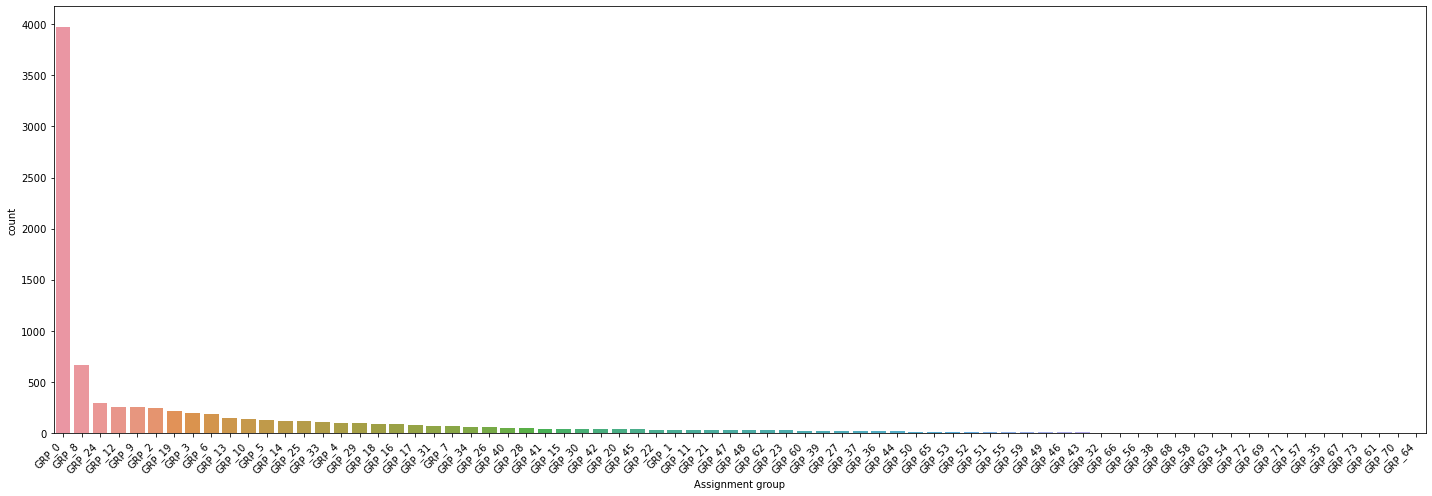

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(20,7))
cplt = sns.countplot(clean_df['Assignment group'],order=group_vc.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

There are 74 groups, with the most frequent one being Group 0 with frequncy 3976. The target variable is highly skewed and imbalanced. Not only group 0 has the majority of tickets assigned, the rest of the groups are also imbalanced with more than 25% of the groups having less than 6 tickets assigned, while the more frequent groups have hundreds.

To treat this, we will merge the groups which have less than 10 tickets assigned to them and also resample data to make it balanced.

Studying the texts for different groups suggests that Group 0 is used for generic account management issues and is also the fallback group for anything that is not categorised into other groups, most likely incorrectly so.

In [56]:
# Merge groups with less than 10 items into one Miscellaneous group
misc_groups = group_vc[group_vc <= 10].index
misc_groups

Index(['GRP_52', 'GRP_51', 'GRP_55', 'GRP_46', 'GRP_59', 'GRP_49', 'GRP_43',
       'GRP_32', 'GRP_66', 'GRP_56', 'GRP_38', 'GRP_68', 'GRP_58', 'GRP_63',
       'GRP_54', 'GRP_72', 'GRP_69', 'GRP_71', 'GRP_57', 'GRP_70', 'GRP_61',
       'GRP_35', 'GRP_67', 'GRP_73', 'GRP_64'],
      dtype='object')

In [57]:
is_misc = clean_df['Assignment group'].isin(misc_groups)

In [58]:
clean_merged_df = clean_df.copy()
clean_merged_df.loc[is_misc,'Assignment group'] = 'GRP_MISC'

In [59]:
clean_merged_df['Assignment group'].isin(misc_groups).any()

False

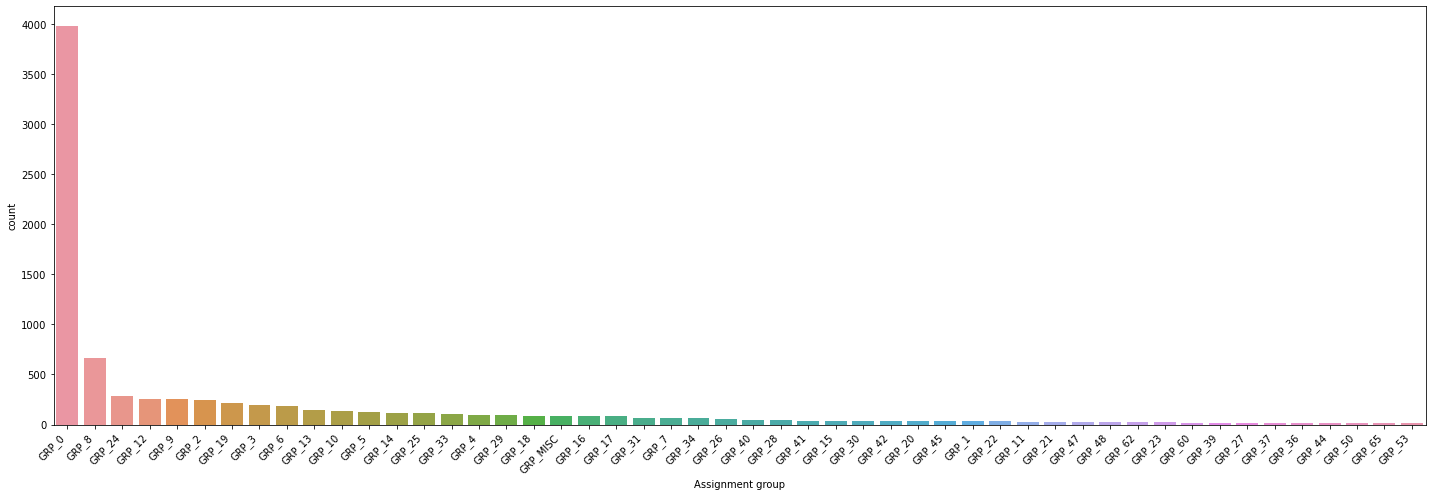

In [60]:
group_vc_new = clean_merged_df['Assignment group'].value_counts()
plt.figure(figsize=(20,7))
cplt = sns.countplot(clean_merged_df['Assignment group'],order=group_vc_new.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Let us view the distribution of tickets for all the groups that are not Group 0.

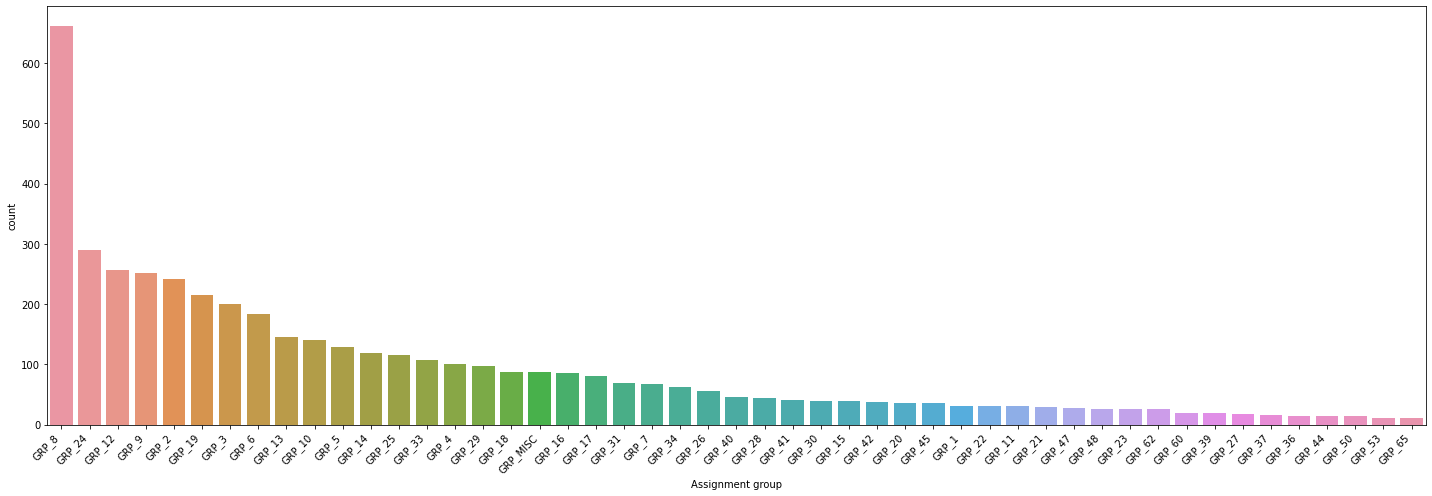

In [61]:
non_group0_df = clean_merged_df[clean_merged_df['Assignment group']!='GRP_0']
group_non0_vc = non_group0_df['Assignment group'].value_counts()
plt.figure(figsize=(20,7))
cplt = sns.countplot(non_group0_df['Assignment group'],order=group_non0_vc.sort_values(ascending=False).index)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Word Distribution
Let's view the distribution of words in the whole corpus and per group.

In [92]:
from wordcloud import WordCloud

def generate_wordcloud(words, name, max_w=20):
    wc = WordCloud(width=400, height=400, max_font_size=40, min_font_size=6, max_words=max_w, colormap='Set2',collocations=False).generate(words)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common {} words of {}".format(max_w,name))
    plt.margins(x=0, y=0)
    plt.show()

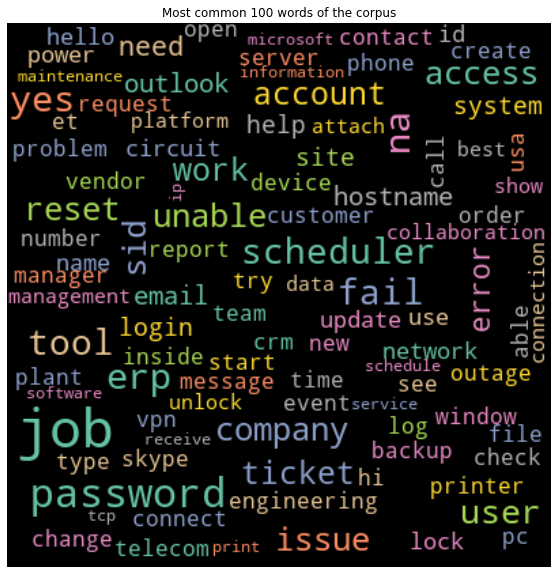

In [63]:
full_text = ' '.join(list(clean_merged_df['Description']))

generate_wordcloud(full_text, 'the corpus', 100)

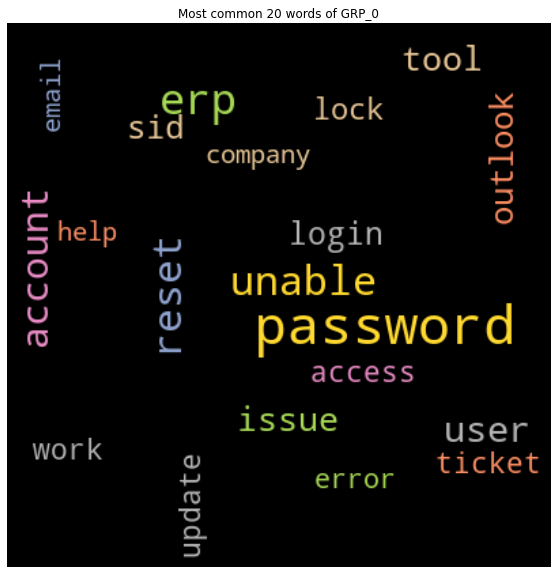

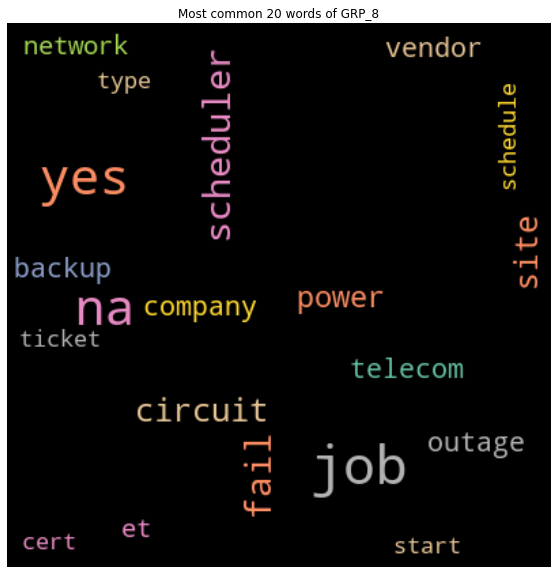

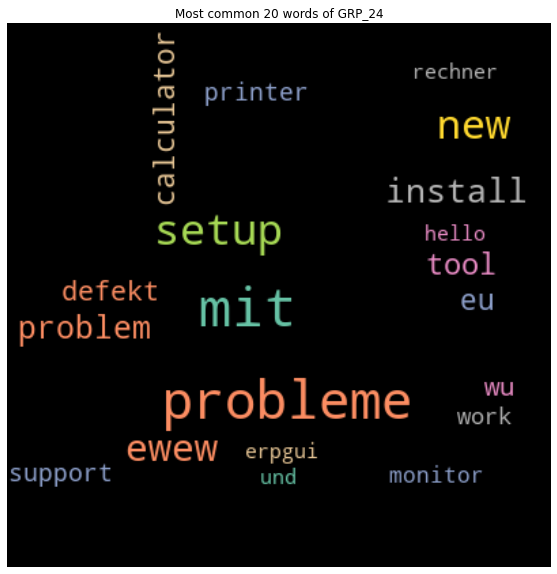

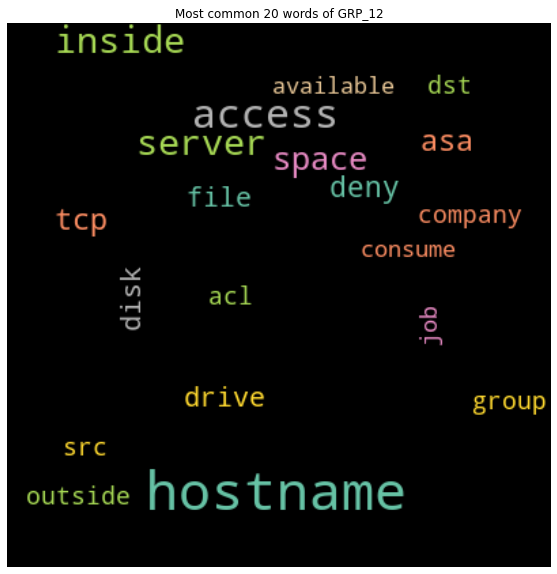

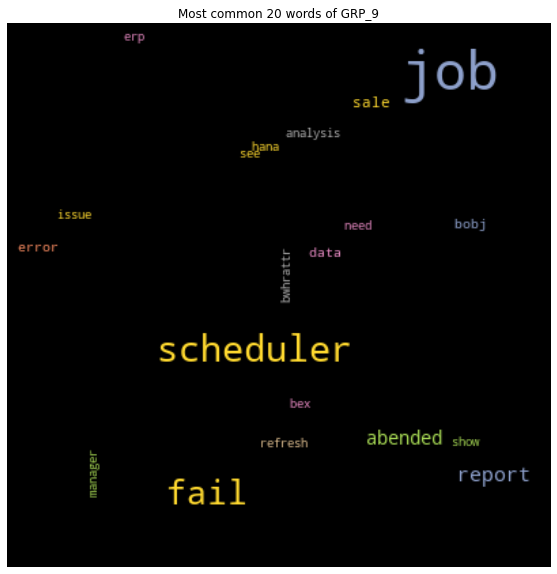

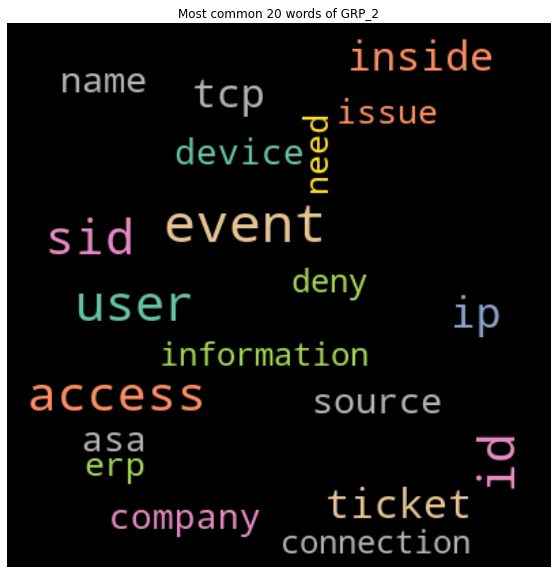

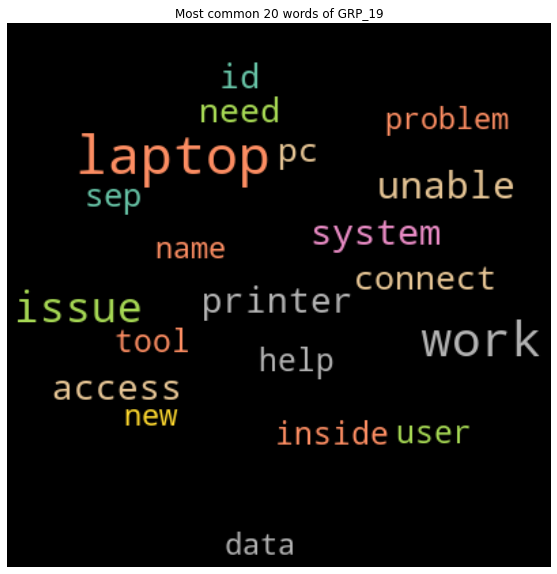

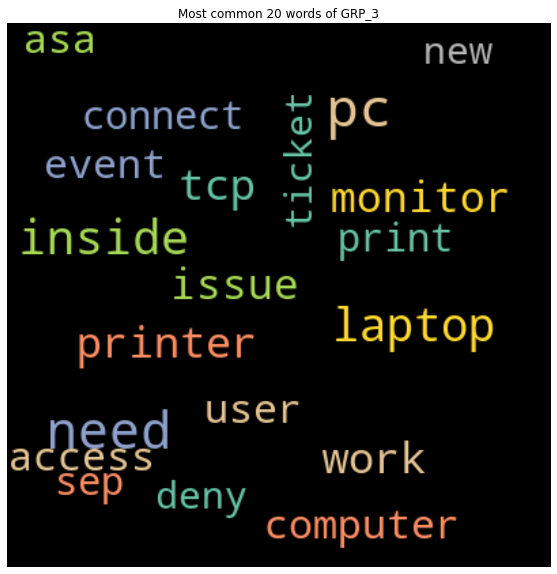

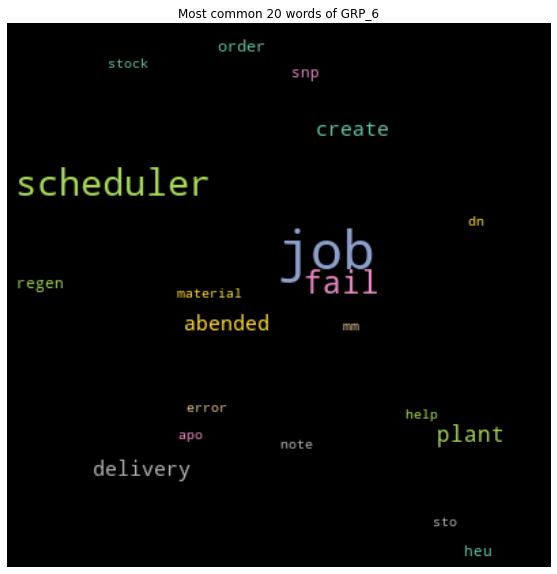

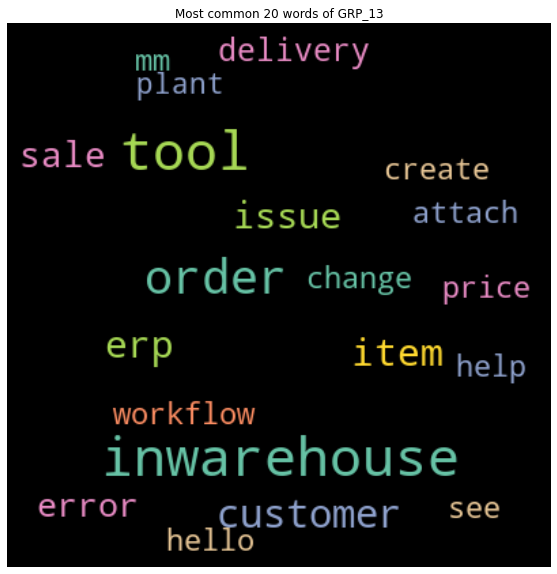

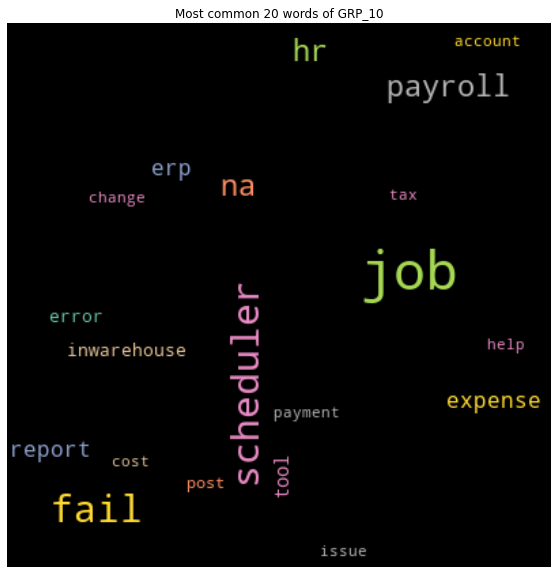

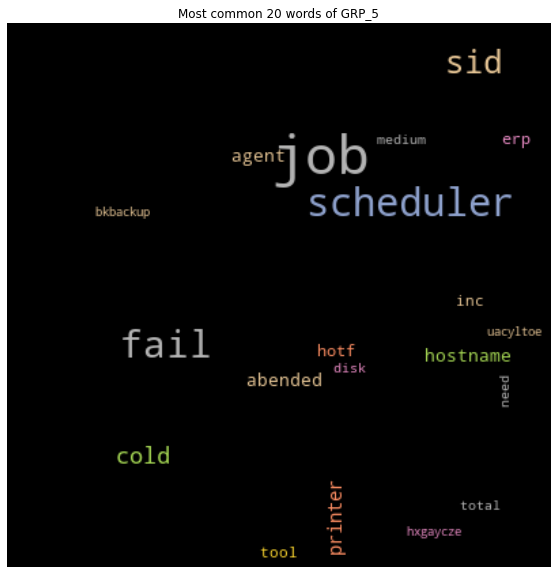

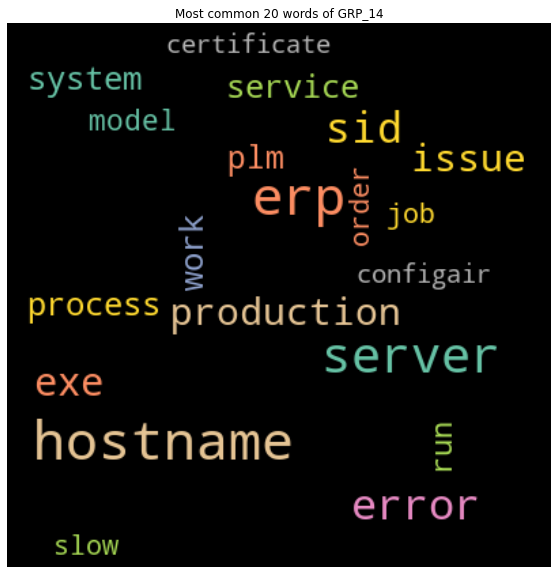

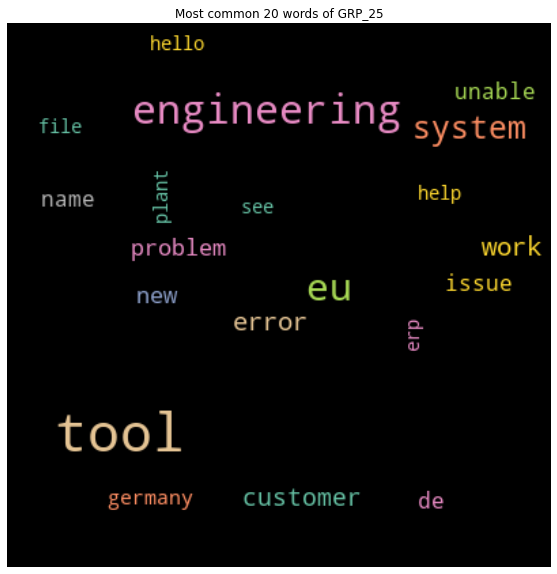

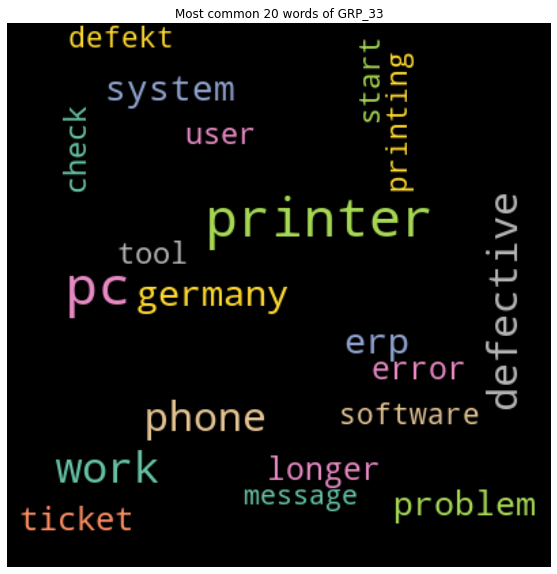

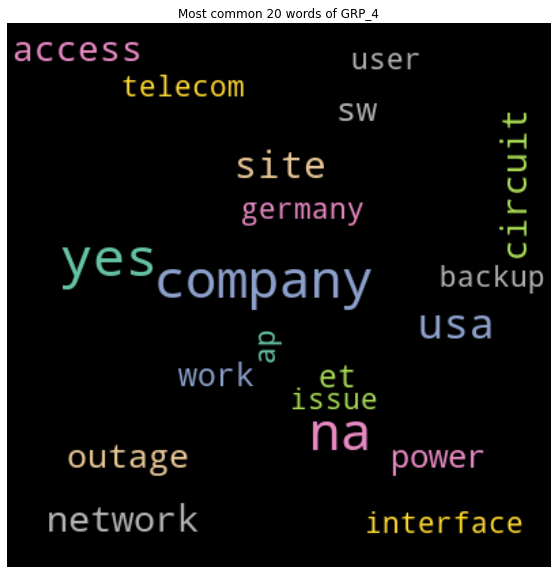

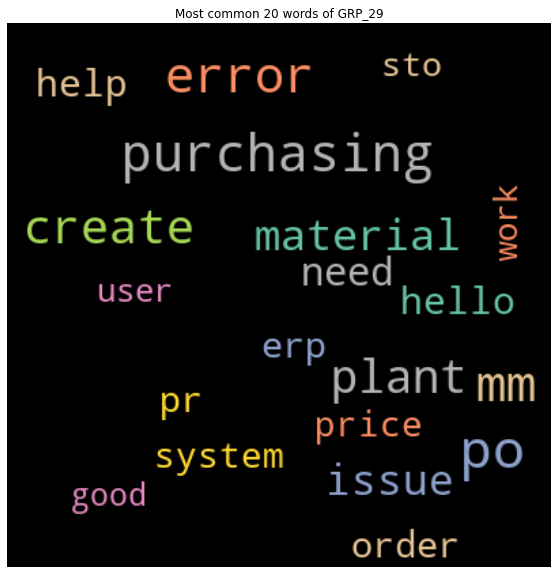

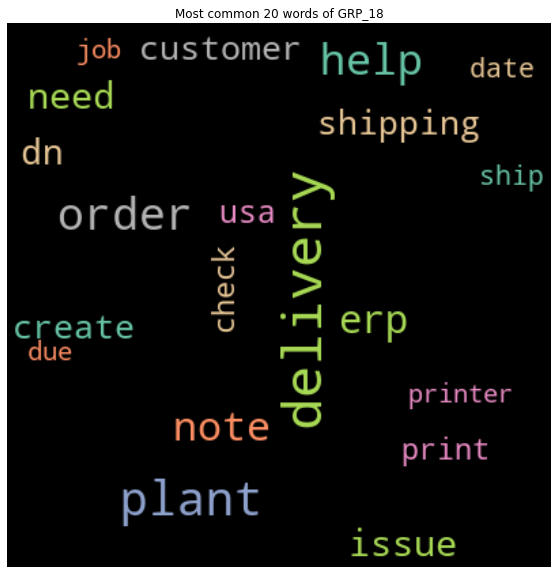

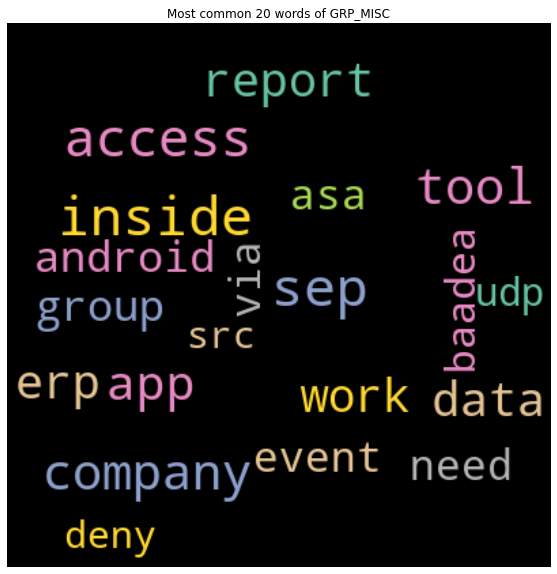

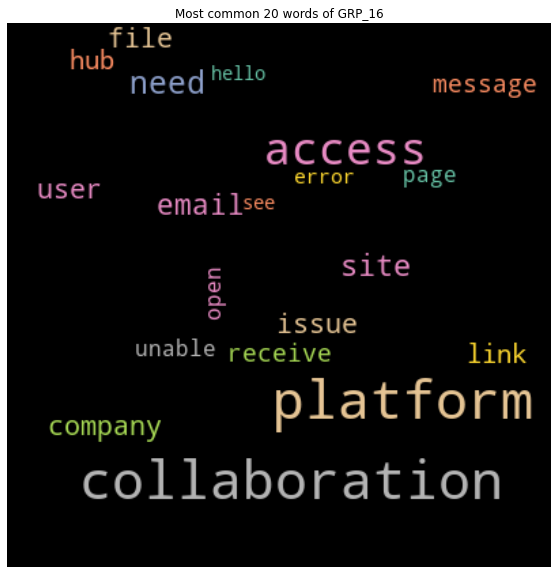

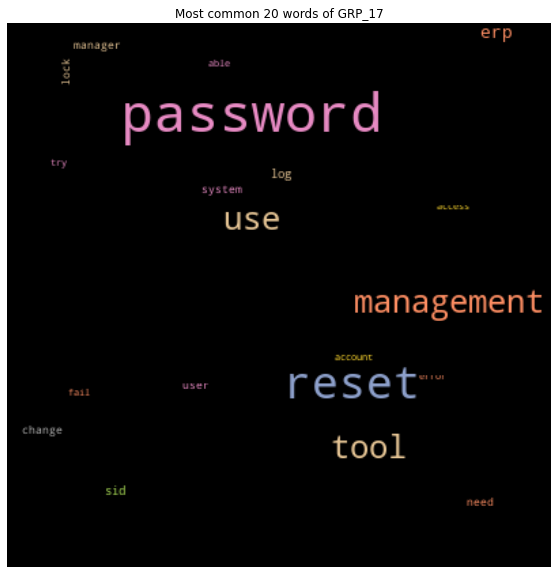

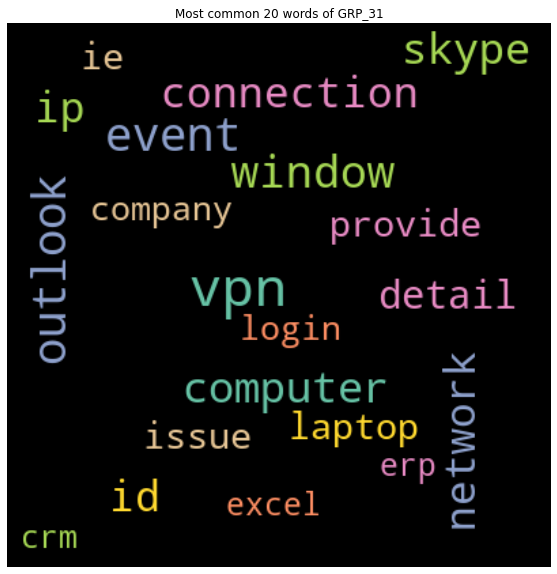

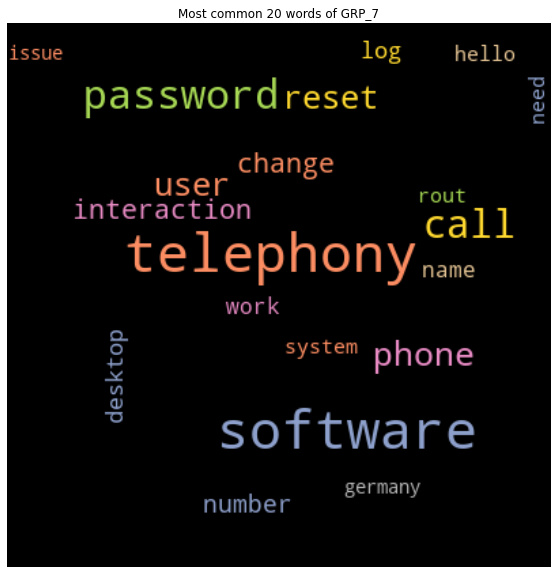

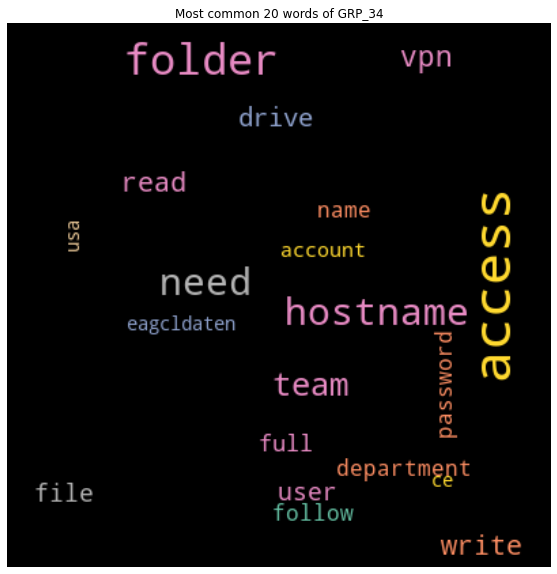

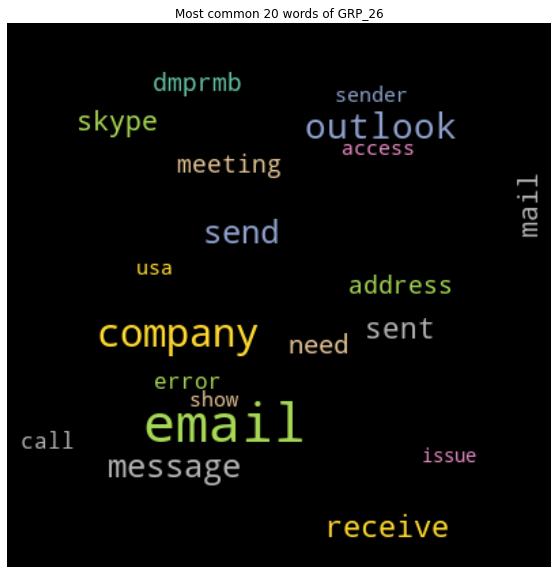

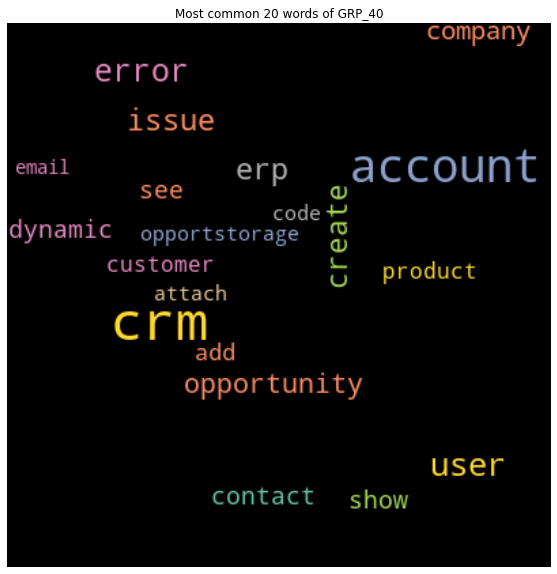

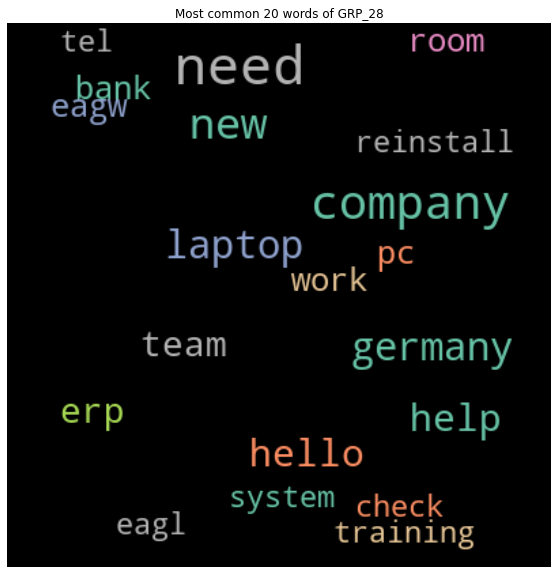

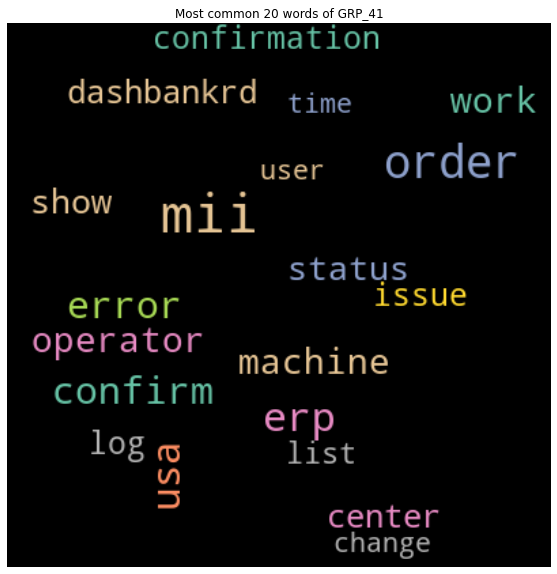

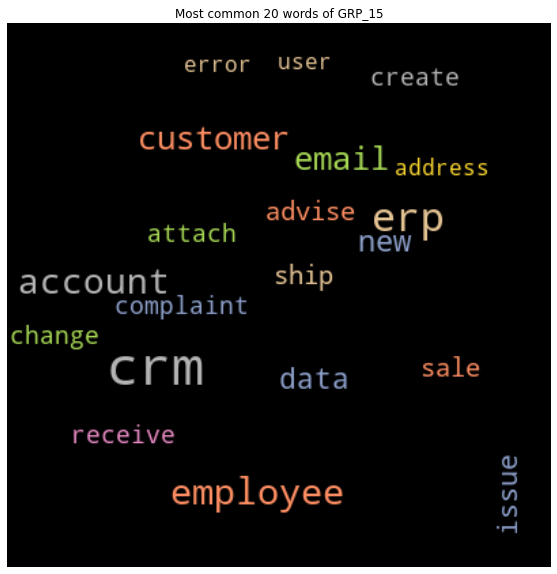

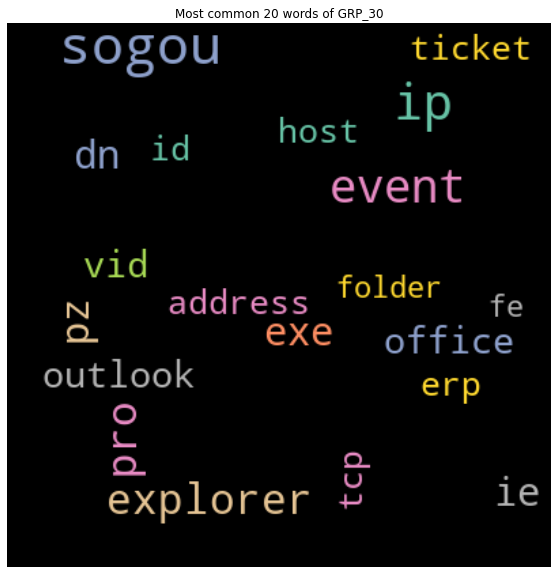

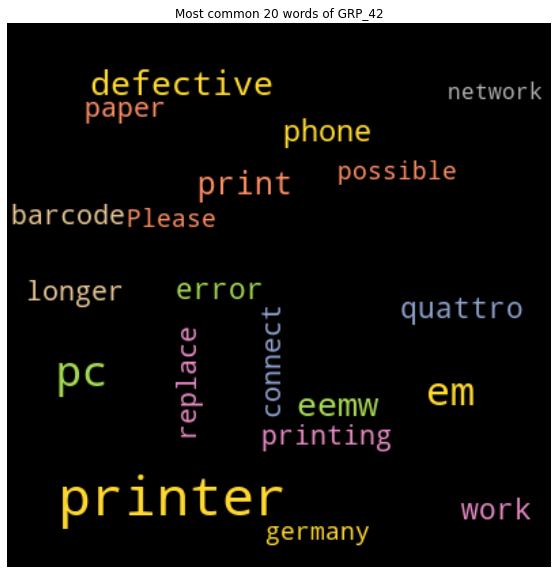

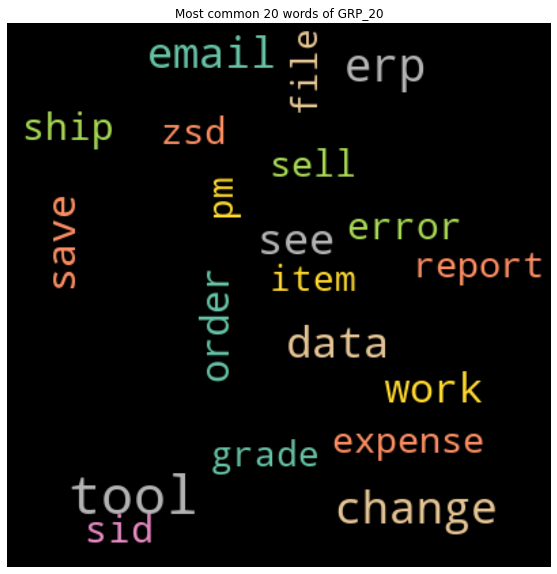

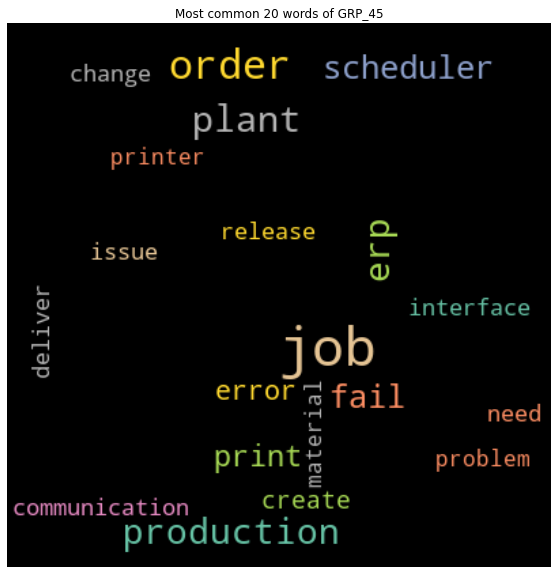

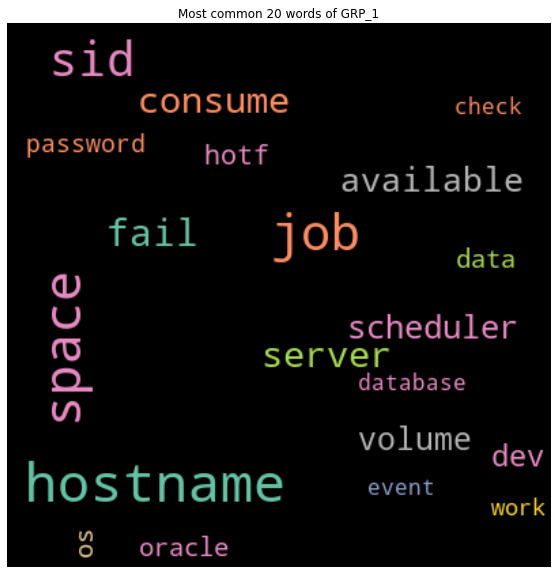

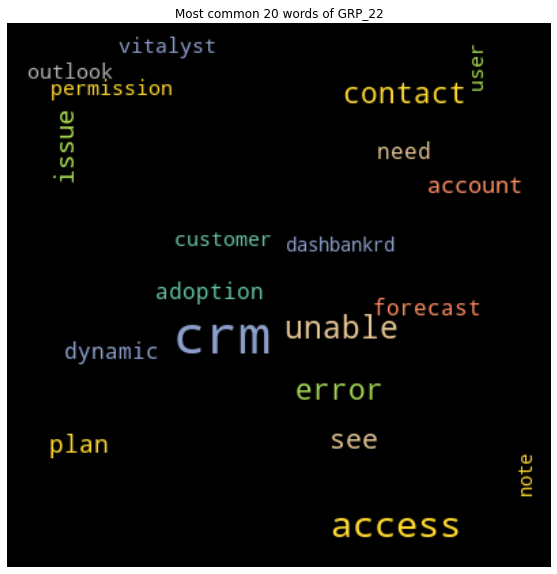

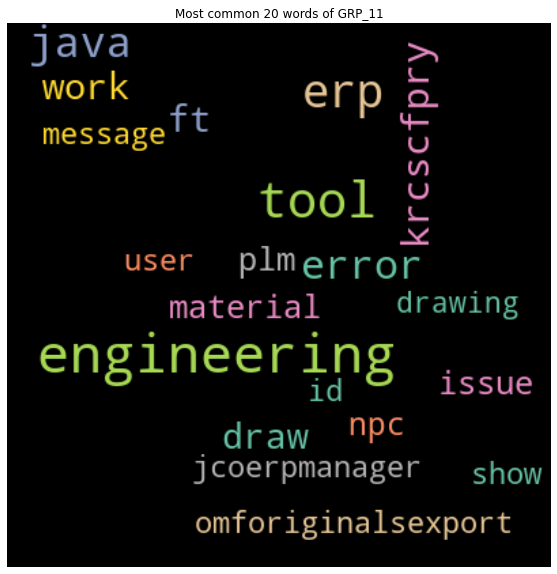

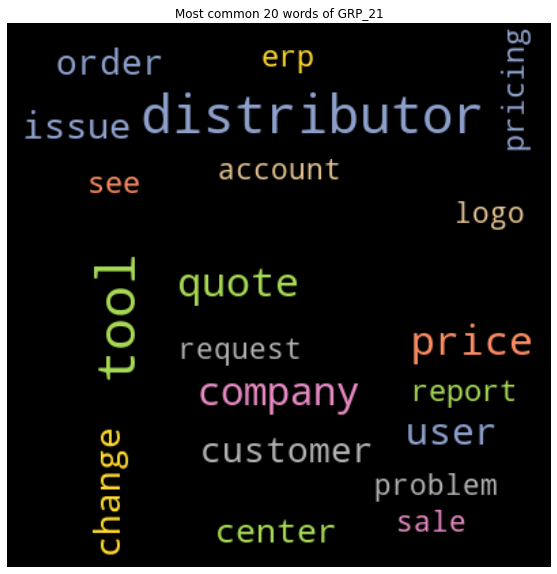

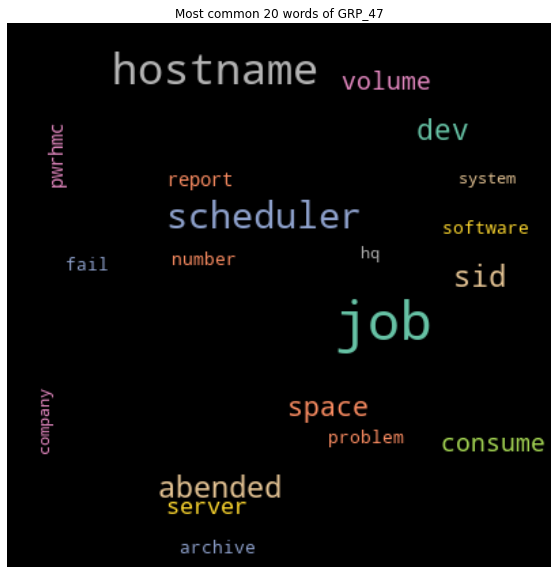

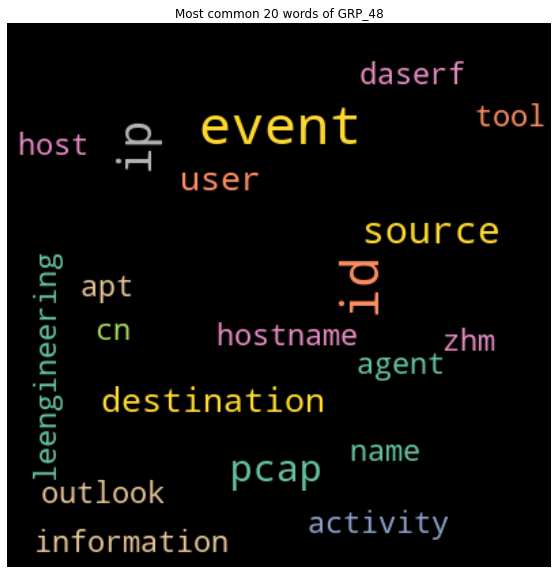

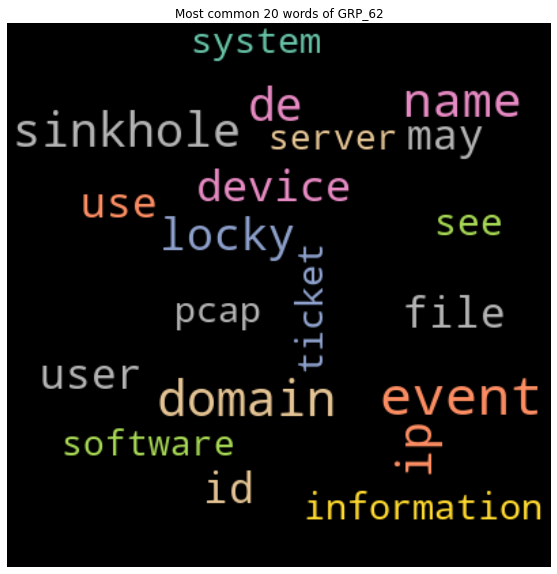

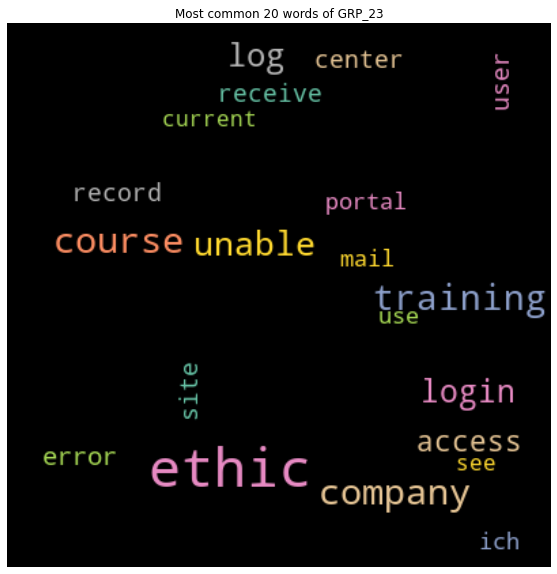

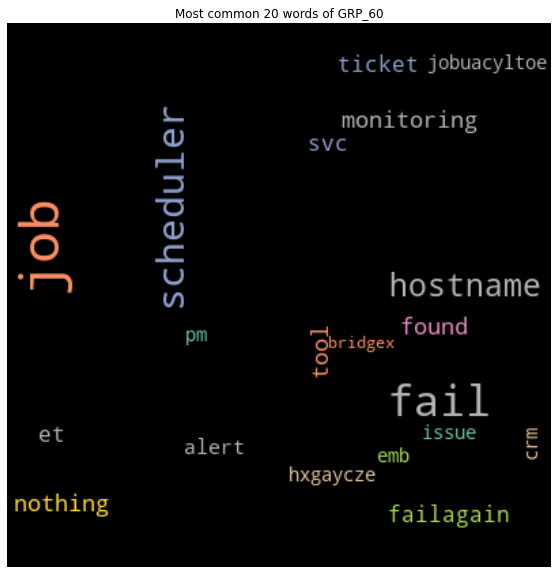

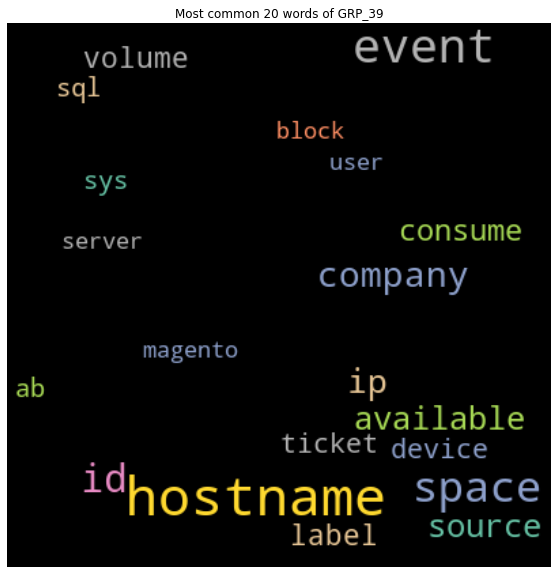

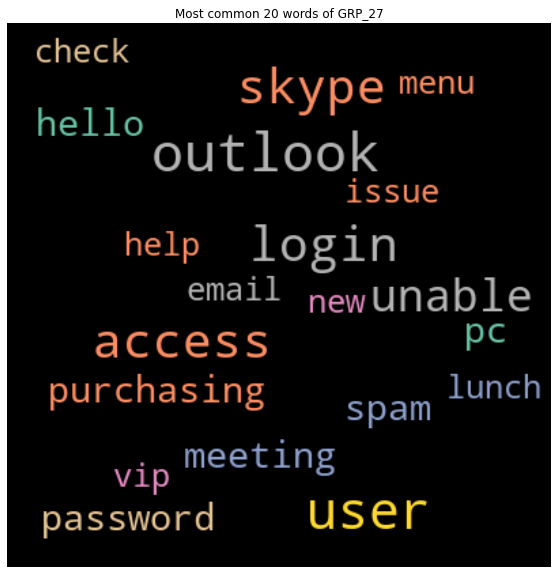

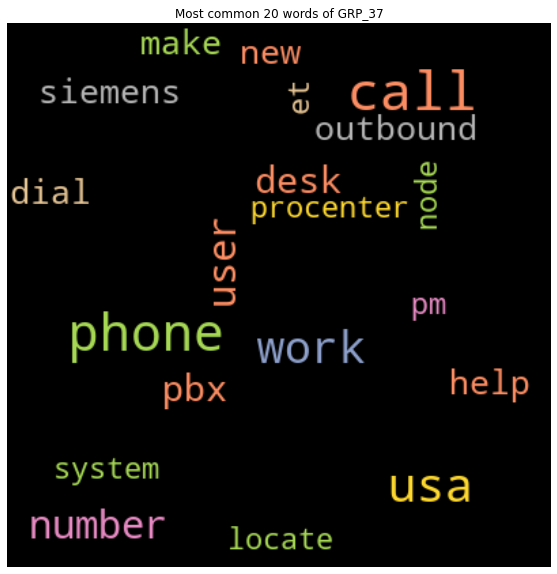

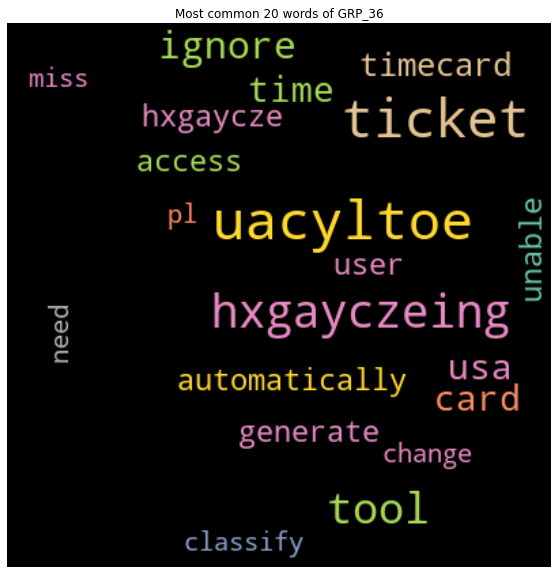

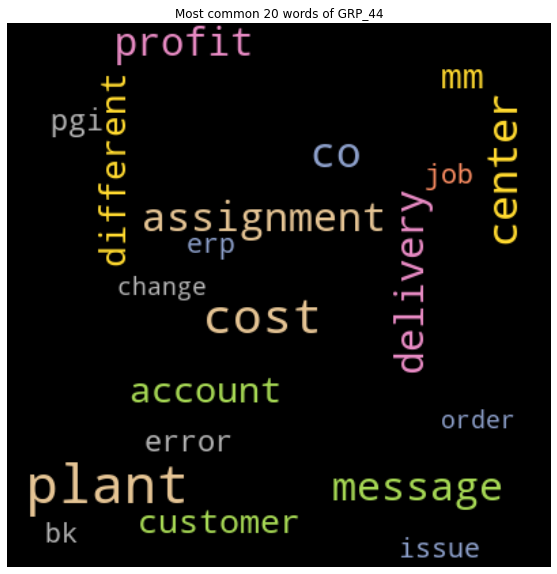

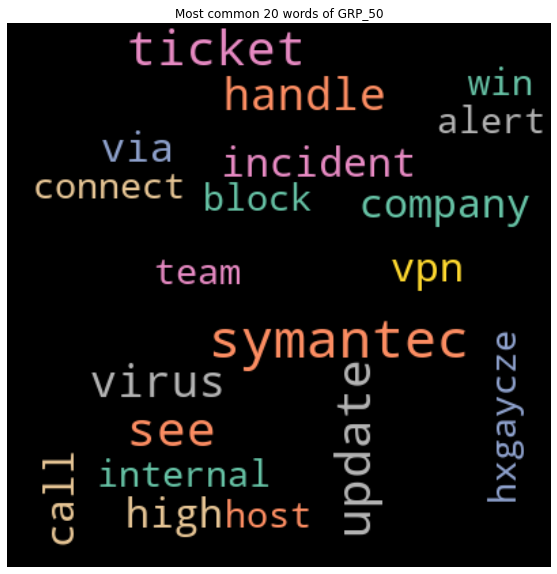

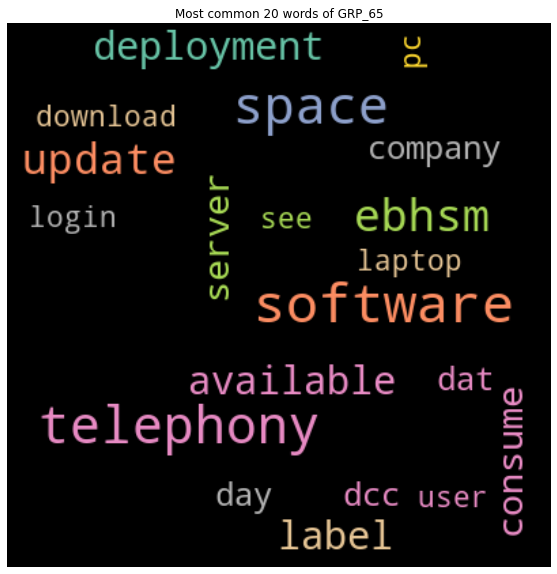

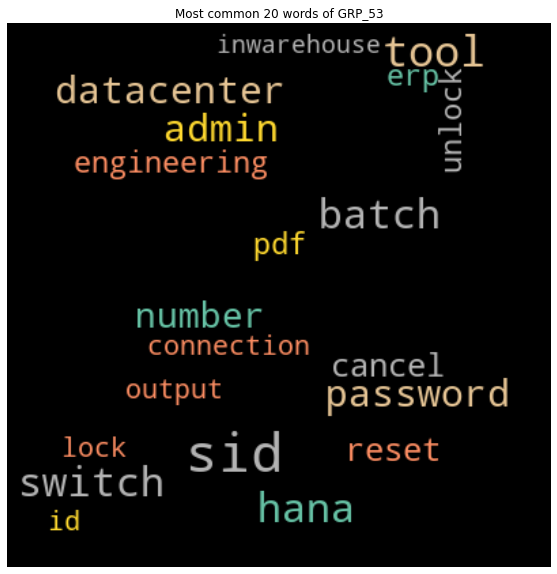

In [93]:
for i,x in enumerate(group_vc_new):
    group = group_vc_new.index[i]
    group_df = clean_merged_df[clean_merged_df ['Assignment group'] == group]
    group_texts = ' '.join(list(group_df['Description']))              
    generate_wordcloud(group_texts,group)

### Resample Assignment Groups

(50000, 4)


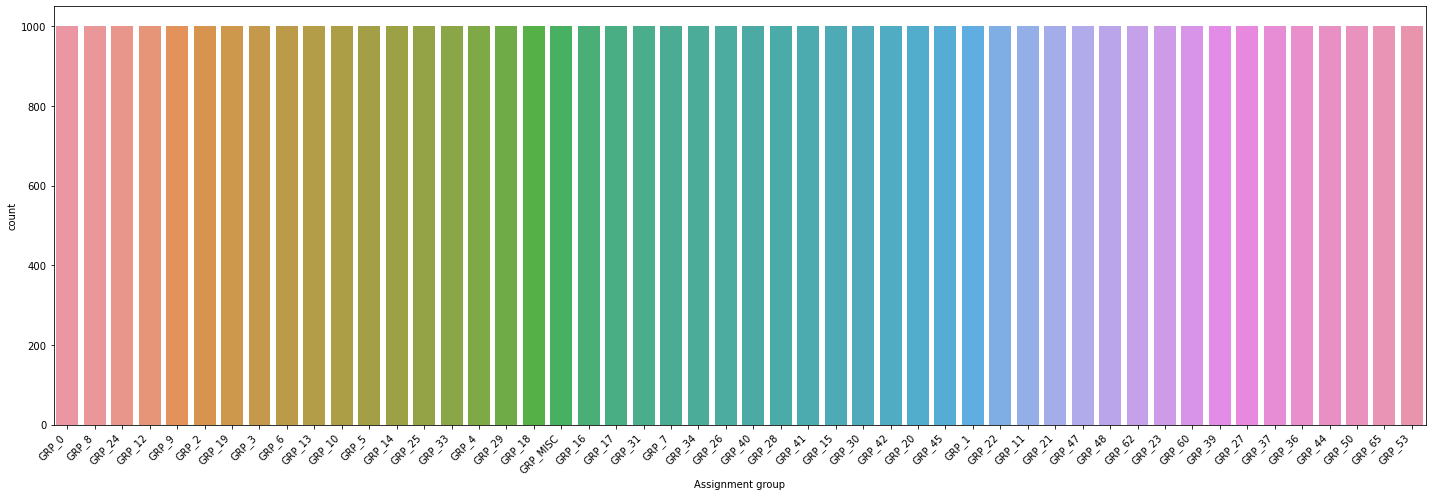

In [65]:
from sklearn.utils import resample

resampled_df = clean_merged_df[0:0]
for grp in group_vc_new.index:
    group_df = clean_merged_df[clean_merged_df['Assignment group'] == grp]
    resampled= resample(group_df, replace=True, n_samples=1000, random_state=7)
    resampled_df = resampled_df.append(resampled)
    
print(resampled_df.shape)

plt.subplots(figsize=(20,7))
cplt=sns.countplot(x='Assignment group', data=resampled_df)
cplt.set_xticklabels(cplt.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Caller Variable
Let us investigate if the 'Caller' variable may influence the assignment to the group.

In [66]:
clean_df['Caller'].value_counts()


bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
spamkgnx nbixueyw      1
khyzsgnv aletvocx      1
jfteqgyc ncazxobk      1
ukqoiswv unjarfoq      1
ztswnaom lrapiwex      1
Name: Caller, Length: 2950, dtype: int64

In [67]:
caller_count = pd.DataFrame(clean_df['Caller'].value_counts())
caller_count.reset_index(inplace=True)
caller_count.columns=['Caller','Count']
caller_count.head()

Caller  Count
0  bpctwhsn kzqsbmtp    810
1  ZkBogxib QsEJzdZO    151
2  fumkcsji sarmtlhy    134
3  rbozivdq gmlhrtvp     87
4  rkupnshb gsmzfojw     71

In [68]:
caller_count.describe()

Count
count  2950.000000
mean      2.881356
std      15.847404
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max     810.000000

In [69]:
def caller_count_groups(caller):
  return len(clean_df[clean_df['Caller']==caller]['Assignment group'].unique())

caller_count['Groups'] = caller_count['Caller'].apply(caller_count_groups)

In [70]:
caller_count['Consider'] = (caller_count['Count'] > 10* caller_count['Groups'])
caller_count.head()


Caller  Count  Groups  Consider
0  bpctwhsn kzqsbmtp    810      16      True
1  ZkBogxib QsEJzdZO    151       9      True
2  fumkcsji sarmtlhy    134       3      True
3  rbozivdq gmlhrtvp     87       2      True
4  rkupnshb gsmzfojw     71      12     False

In [71]:
considered_callers = caller_count[caller_count['Consider']]['Caller']
#considered_callers.apply(lambda s: s.replace(' ',''))
considered_callers

0     bpctwhsn kzqsbmtp
1     ZkBogxib QsEJzdZO
2     fumkcsji sarmtlhy
3     rbozivdq gmlhrtvp
8     olckhmvx pcqobjnd
9     dkmcfreg anwmfvlg
11    efbwiadp dicafxhv
18    jionmpsf wnkpzcmv
28    niptbwdq csenjruz
39    qftpazns fxpnytmk
51    mdbegvct dbvichlg
54    wrcktgbd wzrgyunp
55    eqzibjhw ymebpoih
Name: Caller, dtype: object

From the above analysis, there are certain users whose tickets are being assigned to a very few groups, therefore, we will test to see if keeping their id will influence the results.

Next steps would be to convert the input to word embeddings and prepare the data for feeding into various models and compare the results. 